In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn
from config import *
from load_data import getTrainingSet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, size_of_hidden_layers, output_size, dropout_rate=0):
        super(FeedForwardNN, self).__init__()
        self.size_of_hidden_layers = size_of_hidden_layers
        self.fc1 = nn.Linear(input_size, size_of_hidden_layers[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        for i in range(1, len(size_of_hidden_layers)):
            setattr(
                self, f'fc{i+1}', nn.Linear(size_of_hidden_layers[i-1], size_of_hidden_layers[i]))
            setattr(
                self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.out = nn.Linear(size_of_hidden_layers[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        for i in range(1, len(self.size_of_hidden_layers)):
            fc = getattr(self, f'fc{i+1}')
            dropout = getattr(self, f'dropout{i+1}')
            x = self.relu(fc(x))
            x = dropout(x)
        x = self.out(x)
        return x

In [2]:
def train_model(model, train_loader, epochs, optimizer, loss_function, verbose=False, save_model=False, val_loader=None):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        outputs = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            # unroll the sequence
            x = x.view(x.size(0), -1)
            output = model.forward(x)
            output = output.squeeze(1)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            if verbose and i % (x.size(0)*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//x.size(0)} loss: {loss.item()}')
            epoch_losses.append(loss.item())
            outputs.append(output)
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch} loss: {losses[-1]}, val_loss: {validate(model, val_loader)}')
    if save_model:
        torch.save(model.state_dict(), 'trained_models/fnn_trained_model.pth')
    return losses, outputs

def validate(network, val_loader):
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            network.eval()
            features = features.view(features.size(0), -1)
            o = network(features.to(device))
            labels = labels.view(-1,1)
            loss = torch.nn.functional.mse_loss(o, labels.to(device))
            losses.append(loss.item())
    losses = np.array(losses)
    losses = losses[~np.isnan(losses)]
    return np.mean(losses)

In [3]:
from config import *
from load_data import getTrainingSet,getValidationSet
from torch.optim import Adam

dataset = getTrainingSet(reshape=False)
validation_set = getValidationSet(reshape=False)
features = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
input_size = features * sequence_length
size_of_hidden_layers = FNN_SIZE_OF_HIDDEN_LAYERS
output_size = OUTPUT_SIZE
epochs = FNN_EPOCHS
learning_rate = LEARNING_RATE
l2_regularization_rate = L2_REGULARIZATION_RATE
batch_size = BATCH_SIZE

model = FeedForwardNN(input_size, size_of_hidden_layers, output_size)
loss_function = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=l2_regularization_rate)

In [4]:

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(
    validation_set, batch_size, shuffle=False)
losses, outputs = train_model(
    model,
    train_dataloader,
    epochs,
    optimizer,
    loss_function,
    verbose=False,
    save_model=True,
    val_loader=val_dataloader
)


Epoch 0 loss: 0.06813807127010298, val_loss: 0.5211309991266629
Epoch 1 loss: 0.034172913965316194, val_loss: 0.5301100713443266
Epoch 2 loss: 0.02642707373463824, val_loss: 0.46845181643554606
Epoch 3 loss: 0.019590475940528786, val_loss: 0.4945769938602023
Epoch 4 loss: 0.01713830165702673, val_loss: 0.4701035330250655
Epoch 5 loss: 0.015015917730589488, val_loss: 0.4714827571625579
Epoch 6 loss: 0.016114457434412505, val_loss: 0.46257378930506643
Epoch 7 loss: 0.019089504185714333, val_loss: 0.517614636896816
Epoch 8 loss: 0.013627147425775905, val_loss: 0.47675598459701013
Epoch 9 loss: 0.014245503906344988, val_loss: 0.47664341572416974


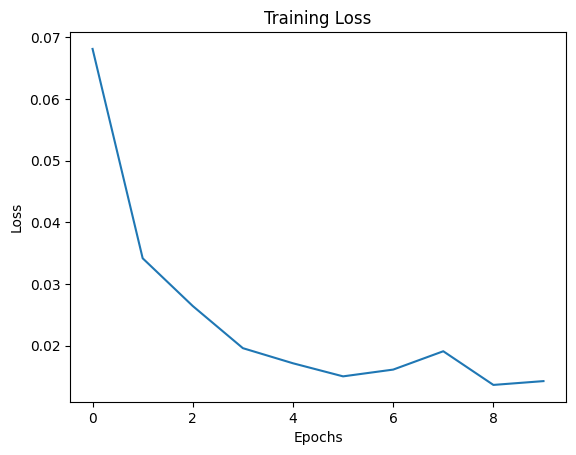

In [5]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [6]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/fnn_trained_model.pth'))

model.eval()

data = getTestData()
y_scaler = data[2]

data = (data[0].astype(np.float32), data[1])

In [4]:
import random
def plot_predictions(predictions, targets, y_scaler,axs):
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    targets = y_scaler.inverse_transform(targets.reshape(-1, 1))
    axs.plot([i for i in range(24,48)], predictions, label='Predictions')
    
    axs.plot(targets[0:48], label='Targets')
    axs.legend()
    

def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
            x = x.view(1, -1)
            output = model.forward(x)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions

def average_error_over_horizons(model, X_test, y_test, forecast_horizon,y_scaler,random_samples=5):
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), random_samples)
    fig, axs = plt.subplots(len(random_numbers)+1, figsize=(10, 5*(len(random_numbers)+1)))
    errors_in_horizon = []
    j=0
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon], y_scaler,axs[j])
            j+=1
                
        error_t =preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]
        error_t = np.square(error_t)
        errors_in_horizon.append(error_t)
        if i % ((len(X_test)-2*forecast_horizon)//10) == 0:
            print(f'{np.round(i*100/(len(X_test)-2*forecast_horizon),-1)}% done',end='\r')

    error_plot = np.mean(errors_in_horizon, axis=0)
    axs[-1].plot( error_plot)
    axs[-1].set_title('Mean squared error over the horizon')
    axs[-1].set_xlabel('Horizon')
    axs[-1].set_ylabel('MSE')
    plt.tight_layout()
    plt.show()
    return np.mean(errors_in_horizon)
        

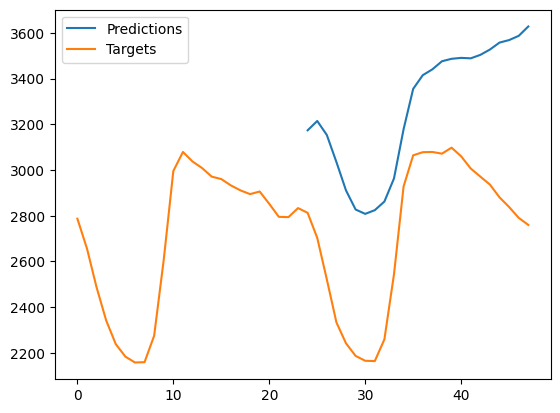

In [8]:
preds=predict_one_horizon(model, data[0][:48], 24, 24)
plot_predictions(preds, data[1], y_scaler,plt)
plt.show()

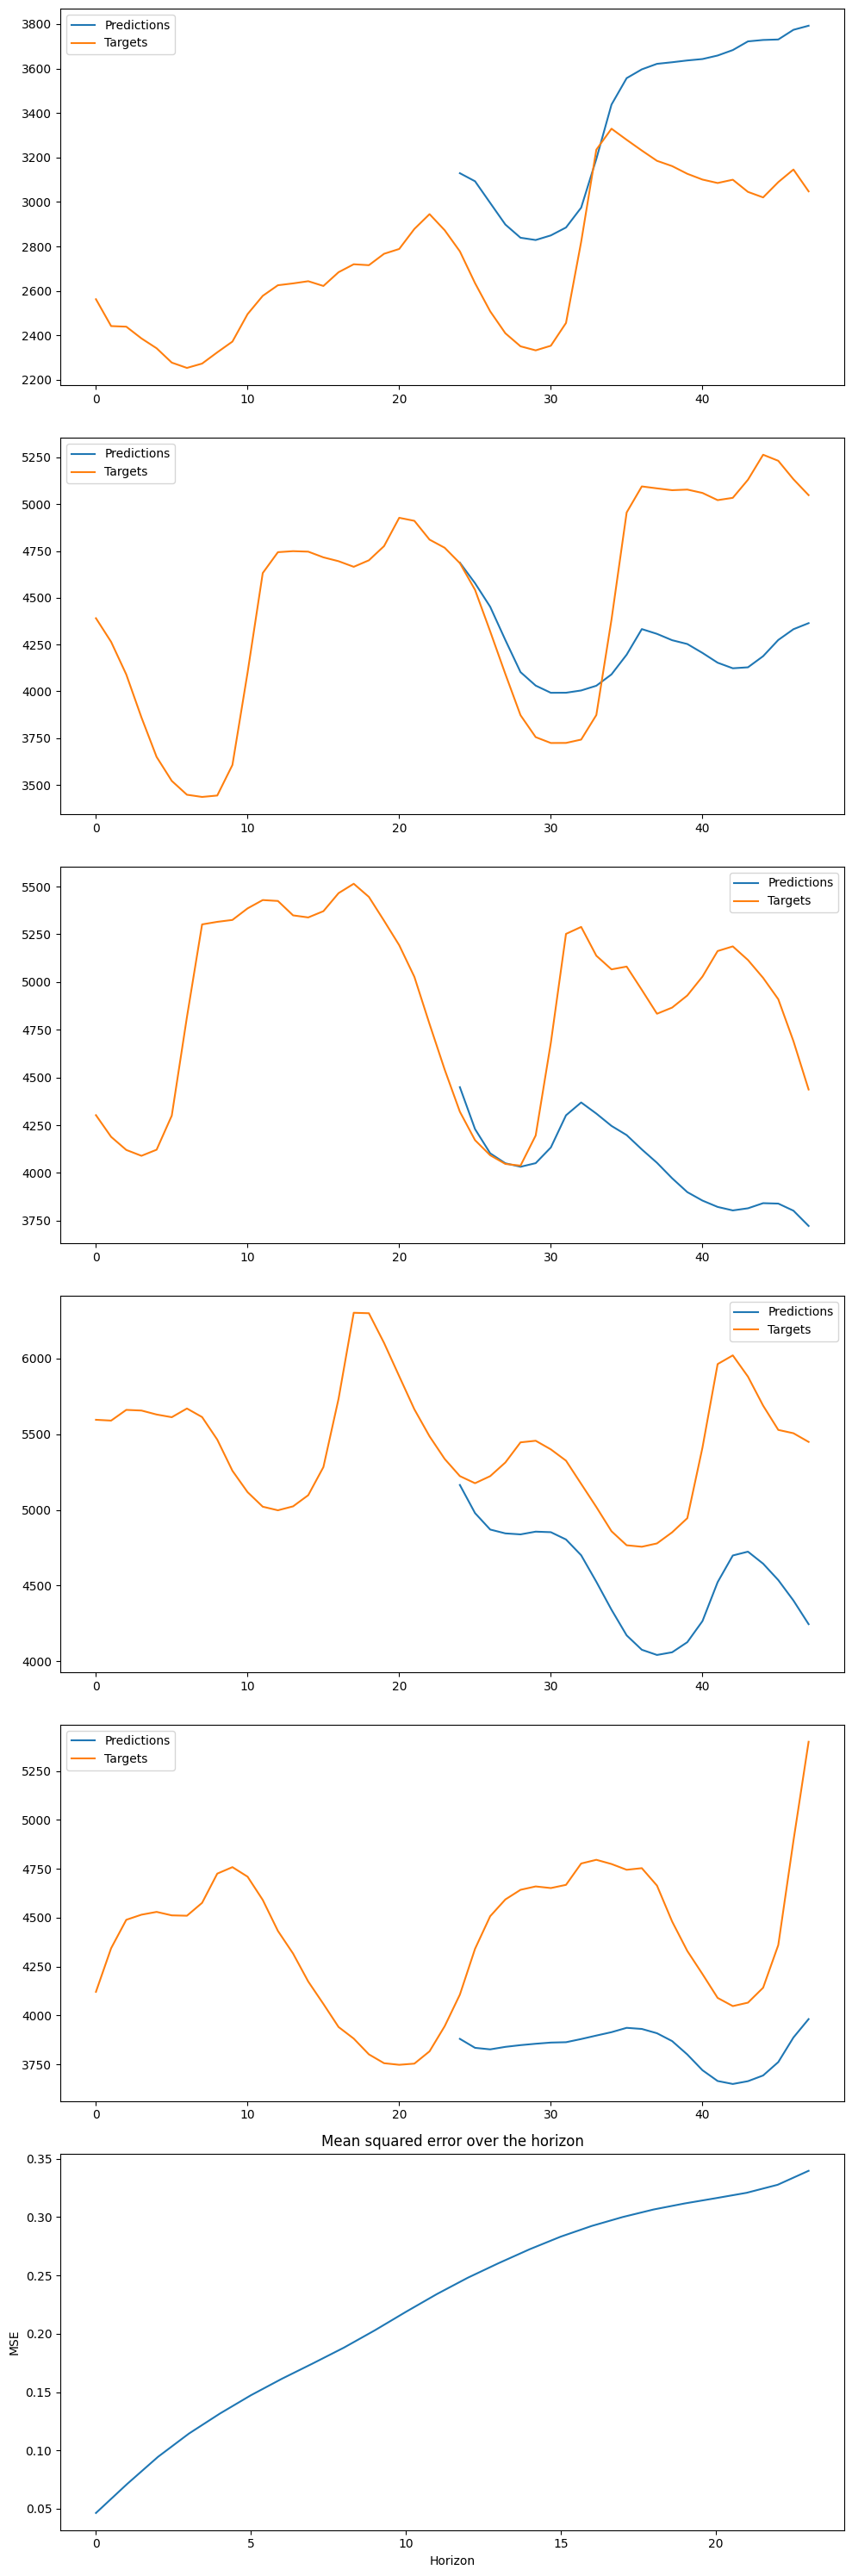

Average error over horizons: 0.2235299838450505


In [9]:
avg_no1 =average_error_over_horizons(model, data[0], data[1], 24, y_scaler)
print(f'Average error over horizons: {avg_no1}')
from load_data import add_entry_to_results
add_entry_to_results('FNN', avg_no1,'testset_results.csv')

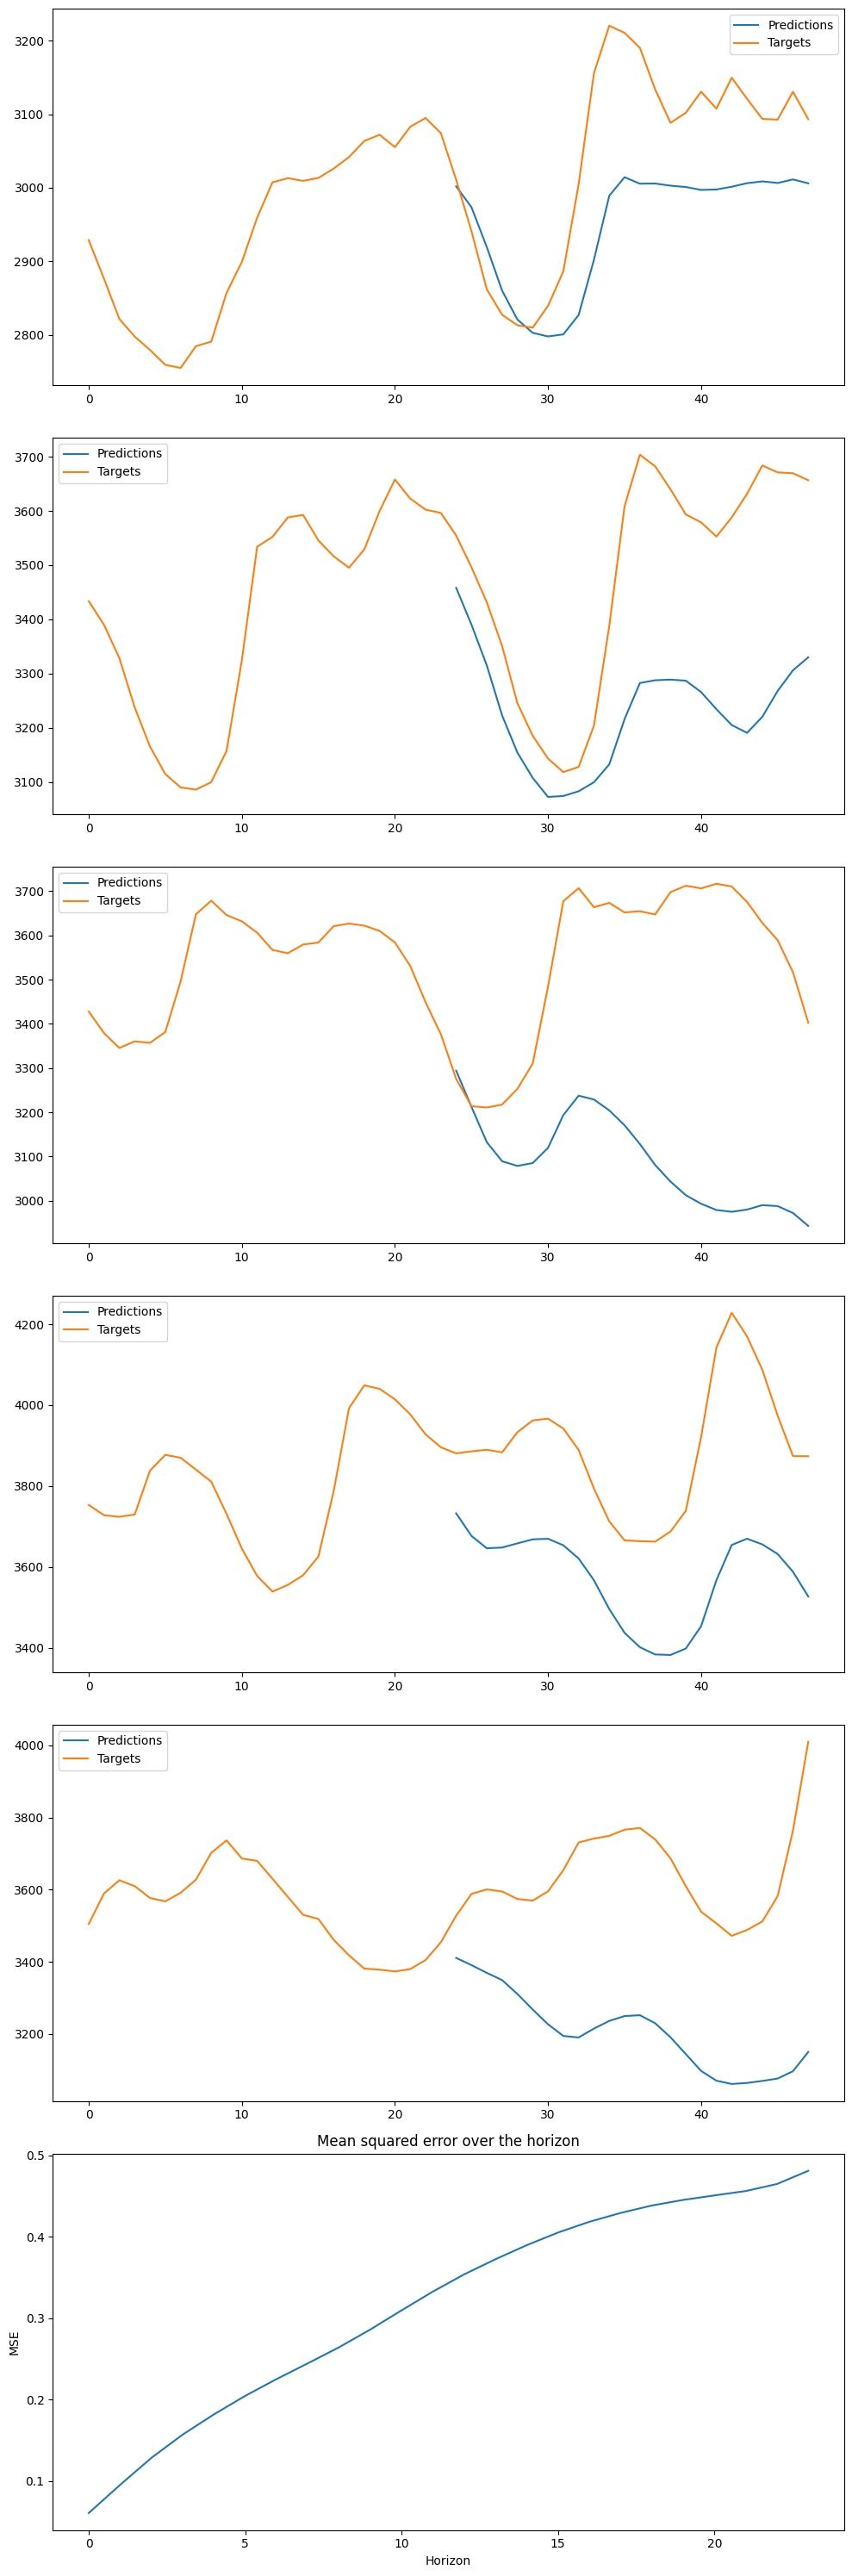

Average error over horizons NO3: 0.31657795506687453


In [10]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/fnn_trained_model.pth'))

model.eval()

data = getTestData(region=3)
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

# Avg error over no3
avg_no3 = average_error_over_horizons(model, data[0], data[1], 24,y_scaler)
print(f'Average error over horizons NO3: {avg_no3}')

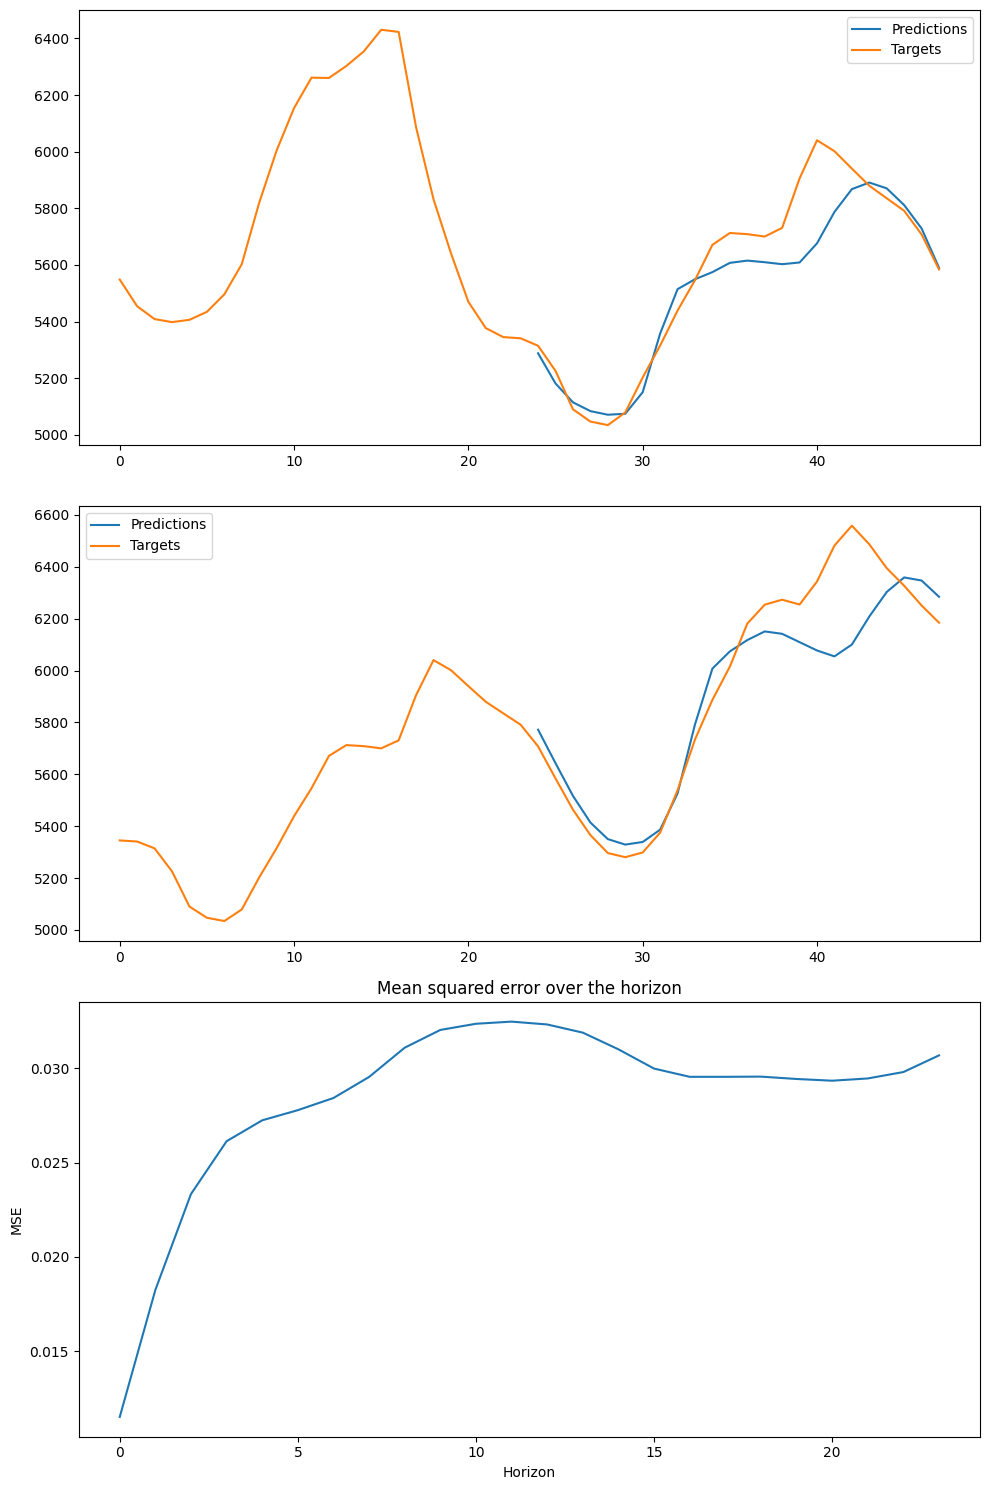

Average error over horizons NO1 Holdout: 0.02844928602329178


In [5]:
from load_data import createTestDataFromHoldOut, add_entry_to_results
import csv
model.load_state_dict(torch.load('trained_models/fnn_trained_model.pth'))

model.eval()

data = createTestDataFromHoldOut(filepath='holdout.csv',region=1)
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

# Avg error over no1 holdout
avg_holdout = average_error_over_horizons(model, data[0], data[1], 24,y_scaler,random_samples=2)
print(f'Average error over horizons NO1 Holdout: {avg_holdout}')
add_entry_to_results("fnn_holdout",avg_holdout,'holdout_results.csv')
